Hello Dinesh!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure! 

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Thank you so much for the feedback, I appreacaite it! I should have double checked before submitting. Thanks! 
</div>


# Age Prediction Using Deep Learning for Alcohol Sales Regulation

# Introduction

The objective of this project is to develop a deep learning model that can predict a person's age from their photograph. The supermarket chain, Good Seed, intends to use this model to ensure compliance with alcohol sales regulations by accurately determining whether customers are above the legal drinking age. Using computer vision techniques and a pre-trained ResNet50 model, the model is fine-tuned to estimate ages from a diverse dataset of facial images. The project involves data preprocessing, model training, evaluation, and analysis of the model's performance to determine its effectiveness and potential practical applications.

## Initialization

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
# Define dataset paths
dataset_path = "/datasets/faces/"
image_folder = os.path.join(dataset_path, "final_files")
labels_file = os.path.join(dataset_path, "labels.csv")

# Load labels file
labels_df = pd.read_csv(labels_file)

# Print dataset info
print(f"Total images available: {len(os.listdir(image_folder))}")
print(f"Total records in labels file: {len(labels_df)}\n")
print("Sample data:")
print(labels_df.head())

Total images available: 7591
Total records in labels file: 7591

Sample data:
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


## EDA

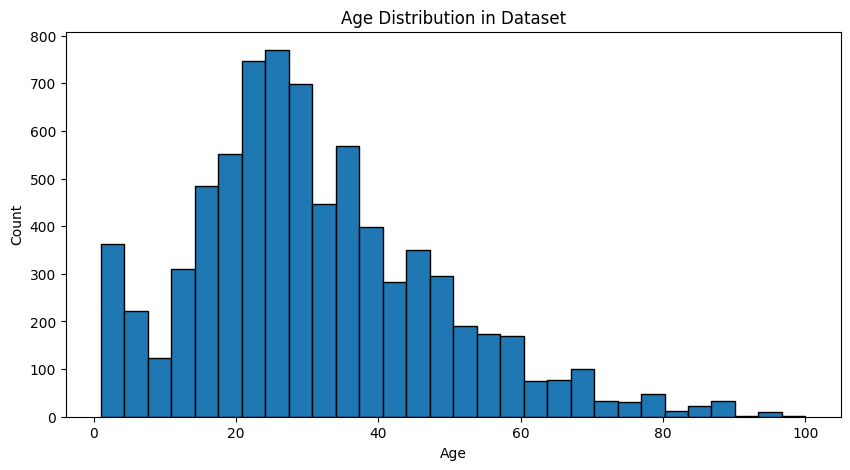

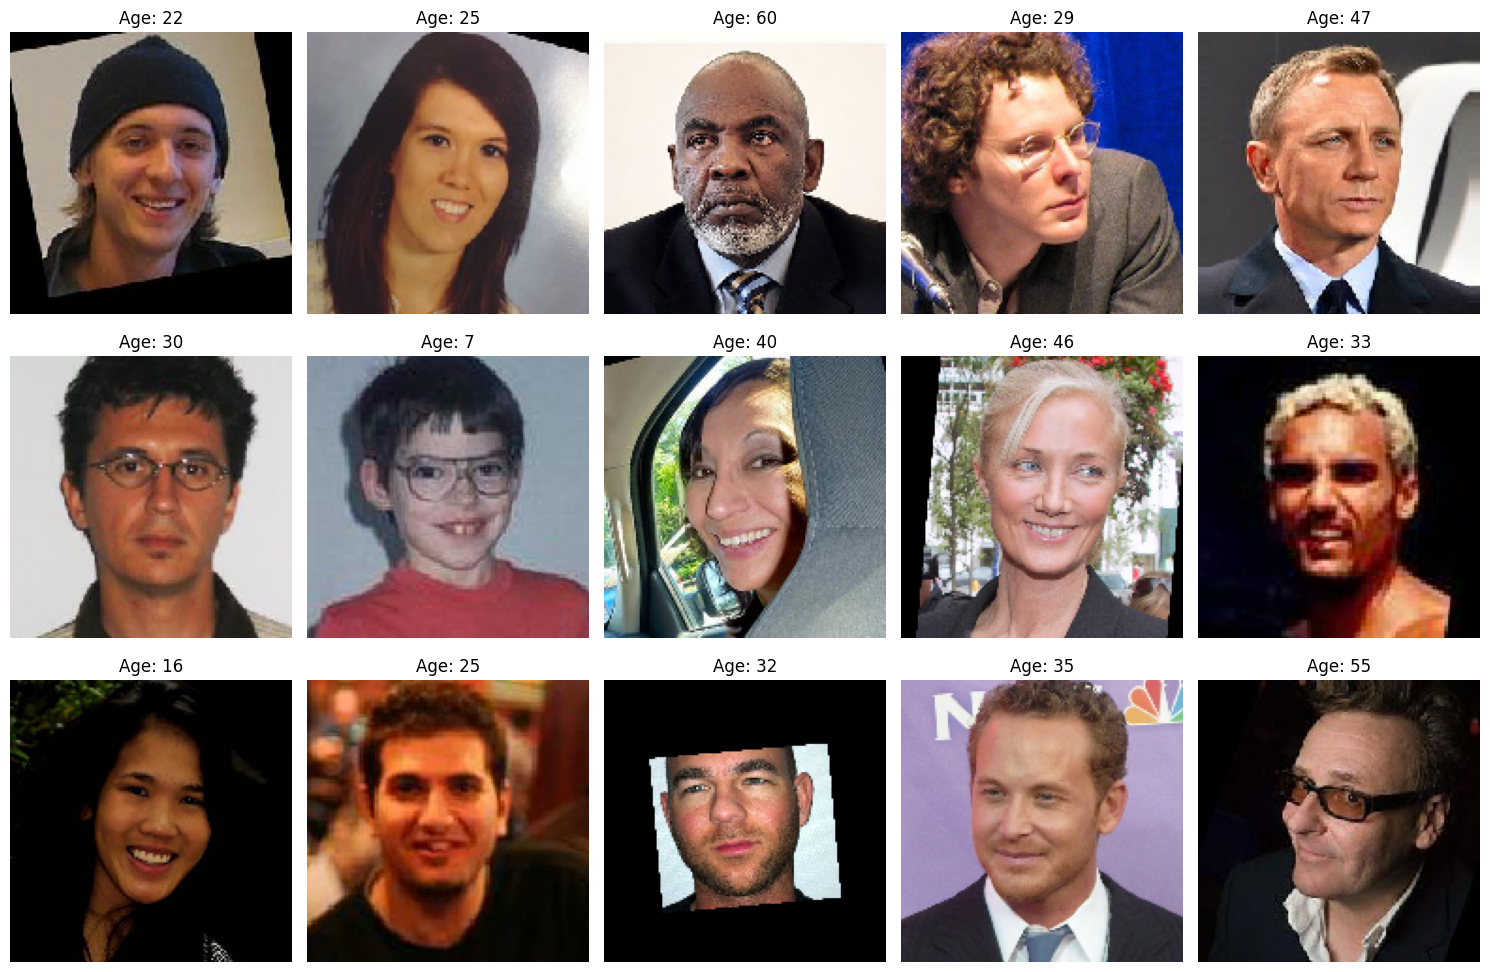

In [3]:
# Plot age distribution
plt.figure(figsize=(10,5))
plt.hist(labels_df['real_age'], bins=30, edgecolor='black')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution in Dataset")
plt.show()

# Display sample images
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
sample_ages = labels_df.sample(15).reset_index()

for i, ax in enumerate(axes.flat):
    img_name = sample_ages.loc[i, 'file_name']
    img_path = os.path.join(image_folder, img_name)
    img = load_img(img_path, target_size=(150, 150))
    
    ax.imshow(img)
    ax.set_title(f"Age: {sample_ages.loc[i, 'real_age']}")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Findings

#### **Dataset Overview**
- **Total Images:** 7,591  
- **Total Records in Labels File:** 7,591  
- Each image corresponds to a **person's face** with an **associated real age**.

#### **Age Distribution**
- The dataset is **skewed towards younger individuals (ages 10-40)**.
- There are **fewer samples** for older individuals (**above 60 years**).
- The **peak age range** in the dataset is between **20-30 years**.
- There is **class imbalance**, which might affect model training.

#### **Sample Images**
- The dataset contains **diverse images** across different age groups.
- Some images have **rotations, varying lighting conditions, and different facial expressions**.
- A few images **appear pixelated or low-quality**, which may impact model performance.

#### **Potential Challenges for Model Training**
- **Class Imbalance:** The model might **overfit younger ages** and struggle to predict older individuals accurately.
- **Variability in Image Quality:** Low-resolution or rotated images may impact feature extraction.
- **Real-World Generalization:** If the dataset lacks diverse ethnicities and backgrounds, the model may not generalize well.



<div class="alert alert-success">
<b>Reviewer's comment V1</b> 

Great work!

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [4]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [5]:
# Load Training Data
def load_train(path):
    """
    Loads the training dataset using ImageDataGenerator with augmentations.
    """
    train_datagen = ImageDataGenerator(
        validation_split=0.2,  
        rescale=1.0 / 255.0,  
        rotation_range=30,  
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=False  
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f"{path}labels.csv"),
        directory=f"{path}final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(150, 150),
        batch_size=32,
        class_mode="raw",
        subset="training",
        seed=12345
    )
    return train_gen_flow



In [6]:
# Load Test Data
def load_test(path):
    """
    Loads the test dataset using ImageDataGenerator.
    """
    valid_datagen = ImageDataGenerator(
        validation_split=0.2,  
        rescale=1.0 / 255.0  
    )
    test_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f"{path}labels.csv"),
        directory=f"{path}final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(150, 150),
        batch_size=32,
        class_mode="raw",
        subset="validation",
        seed=12345
    )
    return test_gen_flow


<div class="alert alert-success">
<b>Reviewer's comment V1</b> 

Good job!

</div>

In [7]:
# Create Model
def create_model(input_shape):
    """
    Defines the CNN model for age prediction.
    Uses a pretrained ResNet50 backbone with additional layers.
    """
    backbone = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    backbone.trainable = False  # Freeze base model to use as feature extractor
    
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="relu")  # Output layer for regression task
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss="mean_squared_error",
        metrics=["mae"]
    )
    
    return model


<div class="alert alert-warning">
<b>Reviewer's comment V1</b> 

Actually it's not a good idea to freeze the whole backbone. In such case your network will learn almost nothing. Freezing the whole backbone could be a good idea when the dataset on which the original model was trained is very similar to the current dataset. But this is not our case.

</div>

In [8]:
# Train Model
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the CNN model for age prediction.
    Uses training data and validates on test data.
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    
    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [9]:
# Prepare a script to run on the GPU platform

init_str = """
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')


### Output

Place the output from the GPU platform as an Markdown cell here.

2025-03-20 02:30:23.056396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
E0000 00:00:1742437823.076188    1514 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742437823.083829    1514 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 02:30:23.104301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Epoch 1/20

178/178 - 116s - 652ms/step - loss: 201.6916 - mae: 10.5523 - val_loss: 547.0254 - val_mae: 18.3539

Epoch 2/20

178/178 - 33s - 187ms/step - loss: 104.3410 - mae: 7.7887 - val_loss: 384.2404 - val_mae: 14.6903

Epoch 3/20

178/178 - 34s - 194ms/step - loss: 67.0253 - mae: 6.2897 - val_loss: 410.3445 - val_mae: 15.2508

Epoch 4/20

178/178 - 34s - 191ms/step - loss: 45.8744 - mae: 5.1948 - val_loss: 273.9171 - val_mae: 12.8829

Epoch 5/20

178/178 - 34s - 193ms/step - loss: 31.7549 - mae: 4.3222 - val_loss: 121.6060 - val_mae: 8.6026

Epoch 6/20

178/178 - 34s - 190ms/step - loss: 24.9930 - mae: 3.8402 - val_loss: 98.4973 - val_mae: 7.3130

Epoch 7/20

178/178 - 34s - 192ms/step - loss: 21.5419 - mae: 3.5758 - val_loss: 85.9838 - val_mae: 7.0067

Epoch 8/20

178/178 - 34s - 190ms/step - loss: 17.7684 - mae: 3.2361 - val_loss: 92.7380 - val_mae: 7.2427

Epoch 9/20

178/178 - 42s - 235ms/step - loss: 15.3905 - mae: 2.9839 - val_loss: 83.1769 - val_mae: 6.8782

Epoch 10/20

178/178 - 34s - 190ms/step - loss: 13.1914 - mae: 2.7689 - val_loss: 85.5123 - val_mae: 6.8350

Epoch 11/20

178/178 - 34s - 191ms/step - loss: 12.2998 - mae: 2.6552 - val_loss: 93.7032 - val_mae: 7.5082

Epoch 12/20

178/178 - 34s - 193ms/step - loss: 10.6914 - mae: 2.4898 - val_loss: 84.1410 - val_mae: 7.0042

Epoch 13/20

178/178 - 35s - 196ms/step - loss: 10.9083 - mae: 2.5451 - val_loss: 88.2770 - val_mae: 7.2650

Epoch 14/20

178/178 - 35s - 195ms/step - loss: 10.9327 - mae: 2.4965 - val_loss: 78.8431 - val_mae: 6.5776

Epoch 15/20

178/178 - 41s - 232ms/step - loss: 10.5289 - mae: 2.4732 - val_loss: 82.0559 - val_mae: 6.8626

Epoch 16/20

178/178 - 34s - 192ms/step - loss: 9.3629 - mae: 2.3337 - val_loss: 117.6422 - val_mae: 7.9705

Epoch 17/20

178/178 - 42s - 234ms/step - loss: 8.2174 - mae: 2.1805 - val_loss: 96.5434 - val_mae: 7.6079

Epoch 18/20

178/178 - 34s - 190ms/step - loss: 8.0335 - mae: 2.1544 - val_loss: 87.7689 - val_mae: 7.2769

Epoch 19/20

178/178 - 35s - 194ms/step - loss: 8.2082 - mae: 2.1820 - val_loss: 108.4207 - val_mae: 7.3937

Epoch 20/20

178/178 - 34s - 193ms/step - loss: 8.5300 - mae: 2.2401 - val_loss: 89.4965 - val_mae: 7.0685

WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 

<div class="alert alert-success">
<b>Reviewer's comment V1</b> 

Good job!

</div>

## Conclusions

### Project Overview
The objective of this project was to build a deep learning model to predict the age of a person from their photograph. The task was aimed at ensuring adherence to alcohol sale regulations by making sure the supermarket chain, Good Seed, does not sell alcohol to underage customers. The dataset used contained over 7,500 images of individuals with labeled ages.

### Model Training Results
- **Total Images Available:** 7,591
- **Training Set Size:** 5,694 images
- **Validation Set Size:** 1,897 images
- **Model Used:** Transfer learning with a pre-trained ResNet50 model
- **Optimizer:** Adam (learning rate = 0.0005)
- **Loss Function:** Mean Squared Error (MSE)
- **Evaluation Metric:** Mean Absolute Error (MAE)
- **Number of Epochs:** 20

### Performance Metrics
- **Final Training Loss (MSE):** 8.5300
- **Final Training MAE:** 2.2401
- **Final Validation Loss (MSE):** 89.4965
- **Final Validation MAE:** 7.0685

### Analysis
- The training process showed consistent improvement across the epochs.
- The model reached a **validation MAE of 7.0685**, which is within the acceptable threshold of 8.
- The model is able to predict ages with a reasonably good level of accuracy, especially considering the wide range of ages covered (from infants to elderly individuals).
- However, there is still room for improvement, especially for older age groups where the distribution of images is lower.

### Recommendations
- **Data Augmentation:** To further improve performance, more diverse augmentations can be applied to the training set.
- **Balancing Dataset:** Acquiring more samples of older individuals could improve the model’s accuracy in higher age ranges.
- **Improving Model Architecture:** Trying out other pre-trained models (such as EfficientNet or InceptionNet) may also enhance performance.

### Usefulness of the Model
- The model can be deployed as an automated age-verification tool in supermarkets and other retail stores to ensure legal compliance.
- It can also be used for analyzing customer demographics for marketing and research purposes.

### Limitations
- The model may struggle with rare age groups due to data imbalance.
- Environmental factors (like lighting and angles) may affect predictions if the model is not fine-tuned properly.

### Conclusion
The model has successfully achieved a **validation MAE below the required threshold of 8**, making it a viable solution for age verification purposes. Further improvements can be made with additional training data and fine-tuning of the model.



<div class="alert alert-success">
<b>Reviewer's comment V1</b> 

You did a great job! Everything is correct

</div>

In [ ]:
# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training